In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(12345)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-djnum8xz because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# generate data 
n = 21
f = lambda x: .7*np.sin(5 * x) * (1 - np.tanh(x ** 2))

# precision of prior
alpha = 1.

# precision of noise
s = .2
beta = 1./s**2

x = np.linspace(-1., 1., n)
t = f(x) + s * np.random.randn(n) 

In [3]:
# analytical posterior 
basis = lambda x: jnp.array([1., x, x**2, x**3, x**4, x**5])
Phi = vmap(basis)(x)

# Hessian 
Sinv = alpha*np.eye(Phi.shape[1]) + beta * Phi.T @ Phi 
# Covariance
S = np.linalg.inv(Sinv)
# Mean 
m = beta * S @ Phi.T @ t

In [16]:
# posterior predictive distribution 
x_eval = np.linspace(-1.2, 1.2, 100)
Phi = vmap(basis)(x_eval)
t_hat_true = Phi@m
s_hat_true = np.sqrt(np.einsum('ni,ij,nj->n', Phi, S, Phi))

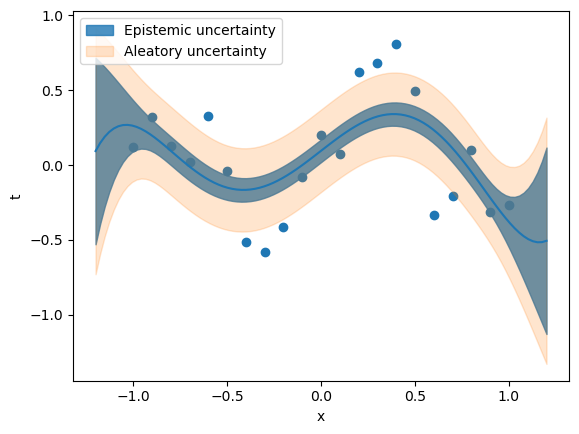

In [17]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat_true)
plt.fill_between(x_eval, t_hat_true-s_hat_true, t_hat_true+s_hat_true, alpha=.8, color='C0', 
                 label='Epistemic uncertainty')
plt.fill_between(x_eval, t_hat_true-(s+s_hat_true), t_hat_true+s+s_hat_true, alpha=.2, color='C1', 
                 label='Aleatory uncertainty')
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [6]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [7]:
# define model that takes in unknown parameters (latent variables)
@jit
def model(x, z):
    
    a, b, c, d, e, f = z
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

# gradient of model w.r.t. parameters
grad_model = jit(jacfwd(model, 1))

# problem dimension
d = 6

# hidden dimension of NN
h = 8

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h, d], [h], [d, h], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1./shape[-1] # np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W2, b2 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)
    
    # output
    z = jnp.einsum('ij,...j->...i', W2, h) + b2
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

# @jit 
# def inv_nn(z, lmbda):
    
#     # weights and biases of nn
#     W1, b1, W2, b2 = reshape(lmbda)
    
#     # hidden layer
#     h = jnp.einsum('ij,...j->...i', inv(W2), z - b2)

#     # input 
#     y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

#     return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
#jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

In [8]:
# ELBO cost function 
def elbo(lmbda, n_sample=20):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    ELBO = 0.
    for yi, zi in zip(y, z):
        # likelihood
        ELBO += beta * np.sum((t - model(x, zi))**2) / 2. / n_sample
        # prior
        ELBO += alpha * np.sum(zi**2) / 2. / n_sample
        # entropy
        ELBO -= log_abs_det(yi, lmbda) / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=20):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # gradient 
    grad_ELBO = 0.
    grad_nn_eval = grad_nn(y, lmbda)
    for gi, yi, zi in zip(grad_nn_eval, y, z):
        # likelihood
        grad_ELBO += beta * np.einsum('t,ti,ij->j', model(x, zi) - t, grad_model(x, zi), gi) / n_sample
        # prior 
        grad_ELBO += alpha * np.einsum('i,ij->j', zi, gi) / n_sample
        # entropy
        grad_ELBO -= grad_log_abs_det(yi, lmbda) / n_sample
    
    return grad_ELBO

In [9]:
# make sure NN is flexible enough to capture true posterior

# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    return jnp.einsum('i,ij,j', m-zi, Sinv, m-zi) / 2.
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=20):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=20):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [10]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=500, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL: {:.3f}, ELBO: {:.3f}".format(kl(params, n_sample=10), elbo(params, n_sample=10)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [11]:
# optimize nn parameters
lmbda = adam_optimizer(elbo, grad_elbo, lmbda)

KL: 24.675, ELBO: 52.092
KL: 21.421, ELBO: 47.171
KL: 19.229, ELBO: 43.625
KL: 20.137, ELBO: 43.648
KL: 18.565, ELBO: 43.258
KL: 18.126, ELBO: 42.023
KL: 16.998, ELBO: 41.114
KL: 16.216, ELBO: 41.663
KL: 16.882, ELBO: 40.798
KL: 16.364, ELBO: 40.278
KL: 15.435, ELBO: 39.095
KL: 15.913, ELBO: 39.558
KL: 14.714, ELBO: 38.898
KL: 14.212, ELBO: 38.604
KL: 14.503, ELBO: 38.785
KL: 13.729, ELBO: 38.941
KL: 15.290, ELBO: 38.940
KL: 14.466, ELBO: 37.765
KL: 14.281, ELBO: 39.230
KL: 13.820, ELBO: 39.815
KL: 14.182, ELBO: 39.083
KL: 14.547, ELBO: 39.153
KL: 13.491, ELBO: 39.902
KL: 14.577, ELBO: 38.491
KL: 13.879, ELBO: 37.390
KL: 14.105, ELBO: 38.976
KL: 13.766, ELBO: 38.409
KL: 13.722, ELBO: 38.959
KL: 14.118, ELBO: 37.118
KL: 14.260, ELBO: 38.169
KL: 13.220, ELBO: 38.865
KL: 13.761, ELBO: 38.316
KL: 14.457, ELBO: 38.874
KL: 14.043, ELBO: 37.623
KL: 14.190, ELBO: 39.411
KL: 13.651, ELBO: 38.661
KL: 13.436, ELBO: 39.043
KL: 14.240, ELBO: 37.823
KL: 13.430, ELBO: 37.901
KL: 13.399, ELBO: 40.522


In [12]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

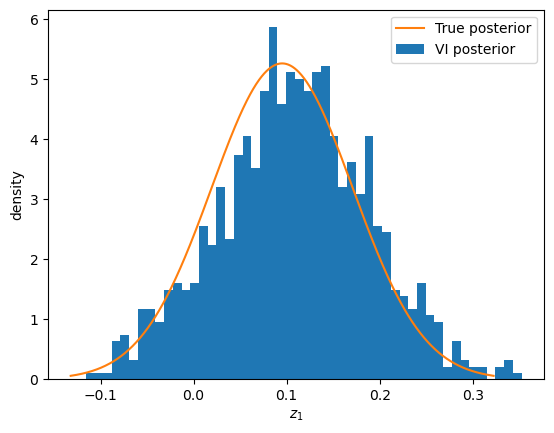

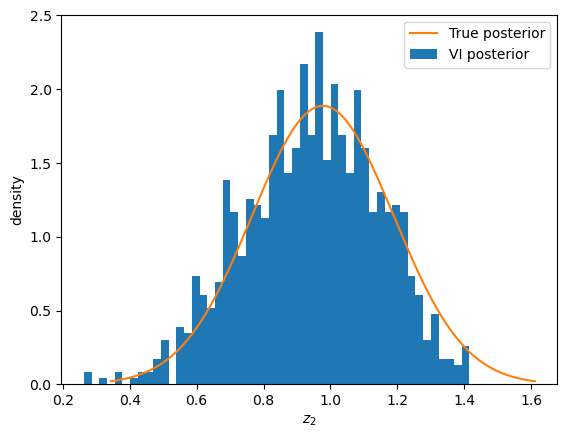

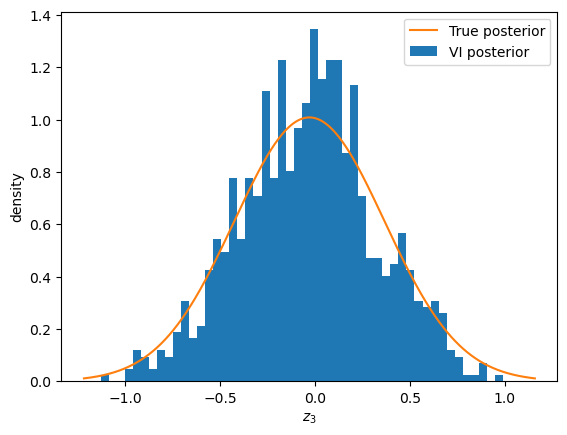

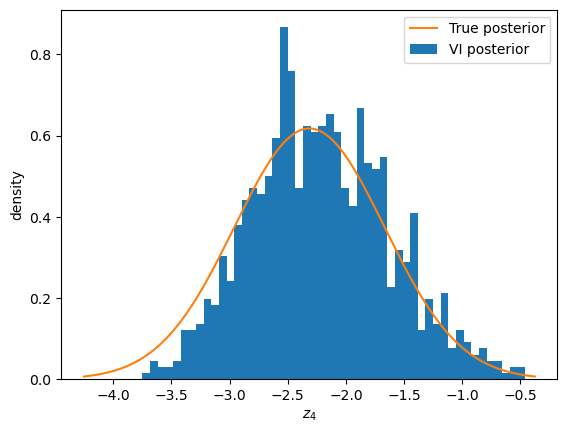

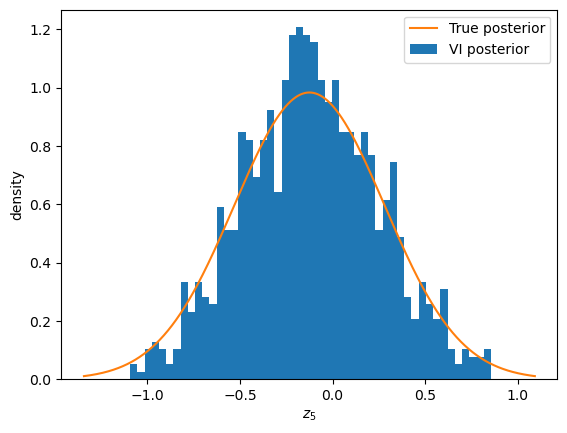

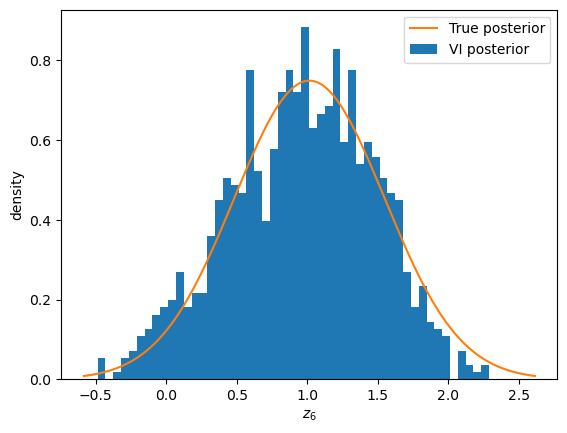

In [13]:
for i, (mean, variance) in enumerate(zip(m, np.diag(S))):

    # Generate data points for x-axis
    x_vals = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # Calculate the corresponding probability density function (PDF) values
    pdf_values = norm.pdf(x_vals, mean, np.sqrt(variance))
    plt.plot(x_vals, pdf_values, c='C1', label='True posterior')
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [18]:
# plot posterior predictive 
t_samples = vmap(model, (None, 0))(x_eval, z)
t_hat = np.mean(t_samples, 0)
s_hat = np.std(t_samples, 0)

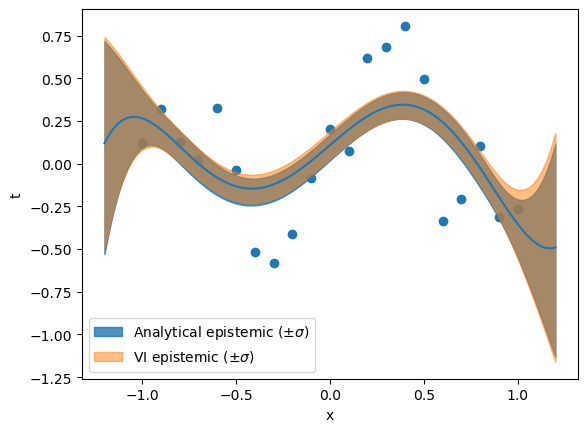

In [23]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat_true-s_hat_true, t_hat_true+s_hat_true, alpha=.8, color='C0', 
                 label='Analytical epistemic ($\pm \sigma$)')
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C1', label='VI epistemic ($\pm \sigma$)')
plt.xlabel("x")
plt.ylabel("t")
plt.legend(loc='lower left')
plt.savefig("figures/linear_regression.png")
plt.show()